In [4]:
import pandas as pd
import pymc3 as pm
import seaborn as sns
import matplotlib.pyplot as plt
from Clean import Clean
import time
import pickle

%matplotlib inline

# Data Prep

In [5]:
with open('./data/fm_2000-2019.pkl','rb') as handle:
    df = pickle.load(handle)

In [16]:
season = '2013-14'
season_list = sorted(list(set(list(df['season']))))
season_index = season_list.index(season)
train_list = season_list[season_index:]
df_train = df[~df['season'].isin(train_list)]
df_train['season'].unique()
df_train
print(season_index)
print(train_list)
print(df_train.shape)

14
['2013-14', '2014-15', '2015-16', '2016-17', '2017-18', '2018-19']
(16775, 459)


In [17]:
vegas_years = ['2013-14','2014-15','2015-16','2016-17','2017-18','2018-19']
print(vegas_years[0][:5] + vegas_years[-1][-2:])
        

2013-19


In [ ]:
n_test = -2000

df = pd.read_csv('./data/FM_2000-2019.csv')
print(df.shape)
df_all = df[df['gp_all_0_a'] >= 30]
df = df_all[0:n_test]
df_test = df_all[n_test:]
print(df.shape)
print(df_test.shape)

In [3]:
games = 30
q = 1

clean = Clean(df,games)
features = clean.get_features(['e-def-rating','e-off-rating','e-pace'],q)
y = clean.get_target(q).values
cols = features.columns
x = features.values
print(x.shape, y.shape)

clean_test = Clean(df_test,games)
features_test = clean_test.get_features(['e-def-rating','e-off-rating','e-pace'],q)
y_test = clean_test.get_target(q).values
cols_test = features_test.columns
x_test = features_test.values
print(x_test.shape, y_test.shape)

(12316, 24) (12316,)
(1979, 24) (1979,)


# Fit a basic linear model

In [4]:
with pm.Model() as basic_model:

    # Priors for unknown model parameters
    alpha = pm.Normal('alpha', mu=0, sigma=10)
    beta = pm.Normal('beta', mu=0, sigma=1, shape=x.shape[1])
    sigma = pm.HalfNormal('sigma', sigma=1)

    # Expected value of outcome
    mu = alpha + pm.math.dot(x,beta)

    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Normal('obs', mu=mu, sigma=sigma, observed=y)

In [6]:
start = time.time()
with basic_model:
    step = pm.NUTS()
    # step = pm.Slice()
    # step = pm.EllipticalSlice()
    trace = pm.sample(2000, step=step, chains=4, cores=4, tune=1000)
    # trace = pm.sample(2000, chains=4, cores=4, tune=1000)
    # trace = pm.sample(chains=4, cores=4)
print('runtime=', (time.time() - start)/60, 'min')

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta, alpha]
Sampling 4 chains:  14%|█▍        | 1732/12000 [03:51<42:42,  4.01draws/s]  

ValueError: Not enough samples to build a trace.

In [6]:
pm.save_trace(trace, './trace/lin_zero')

'./trace/lin_zero'

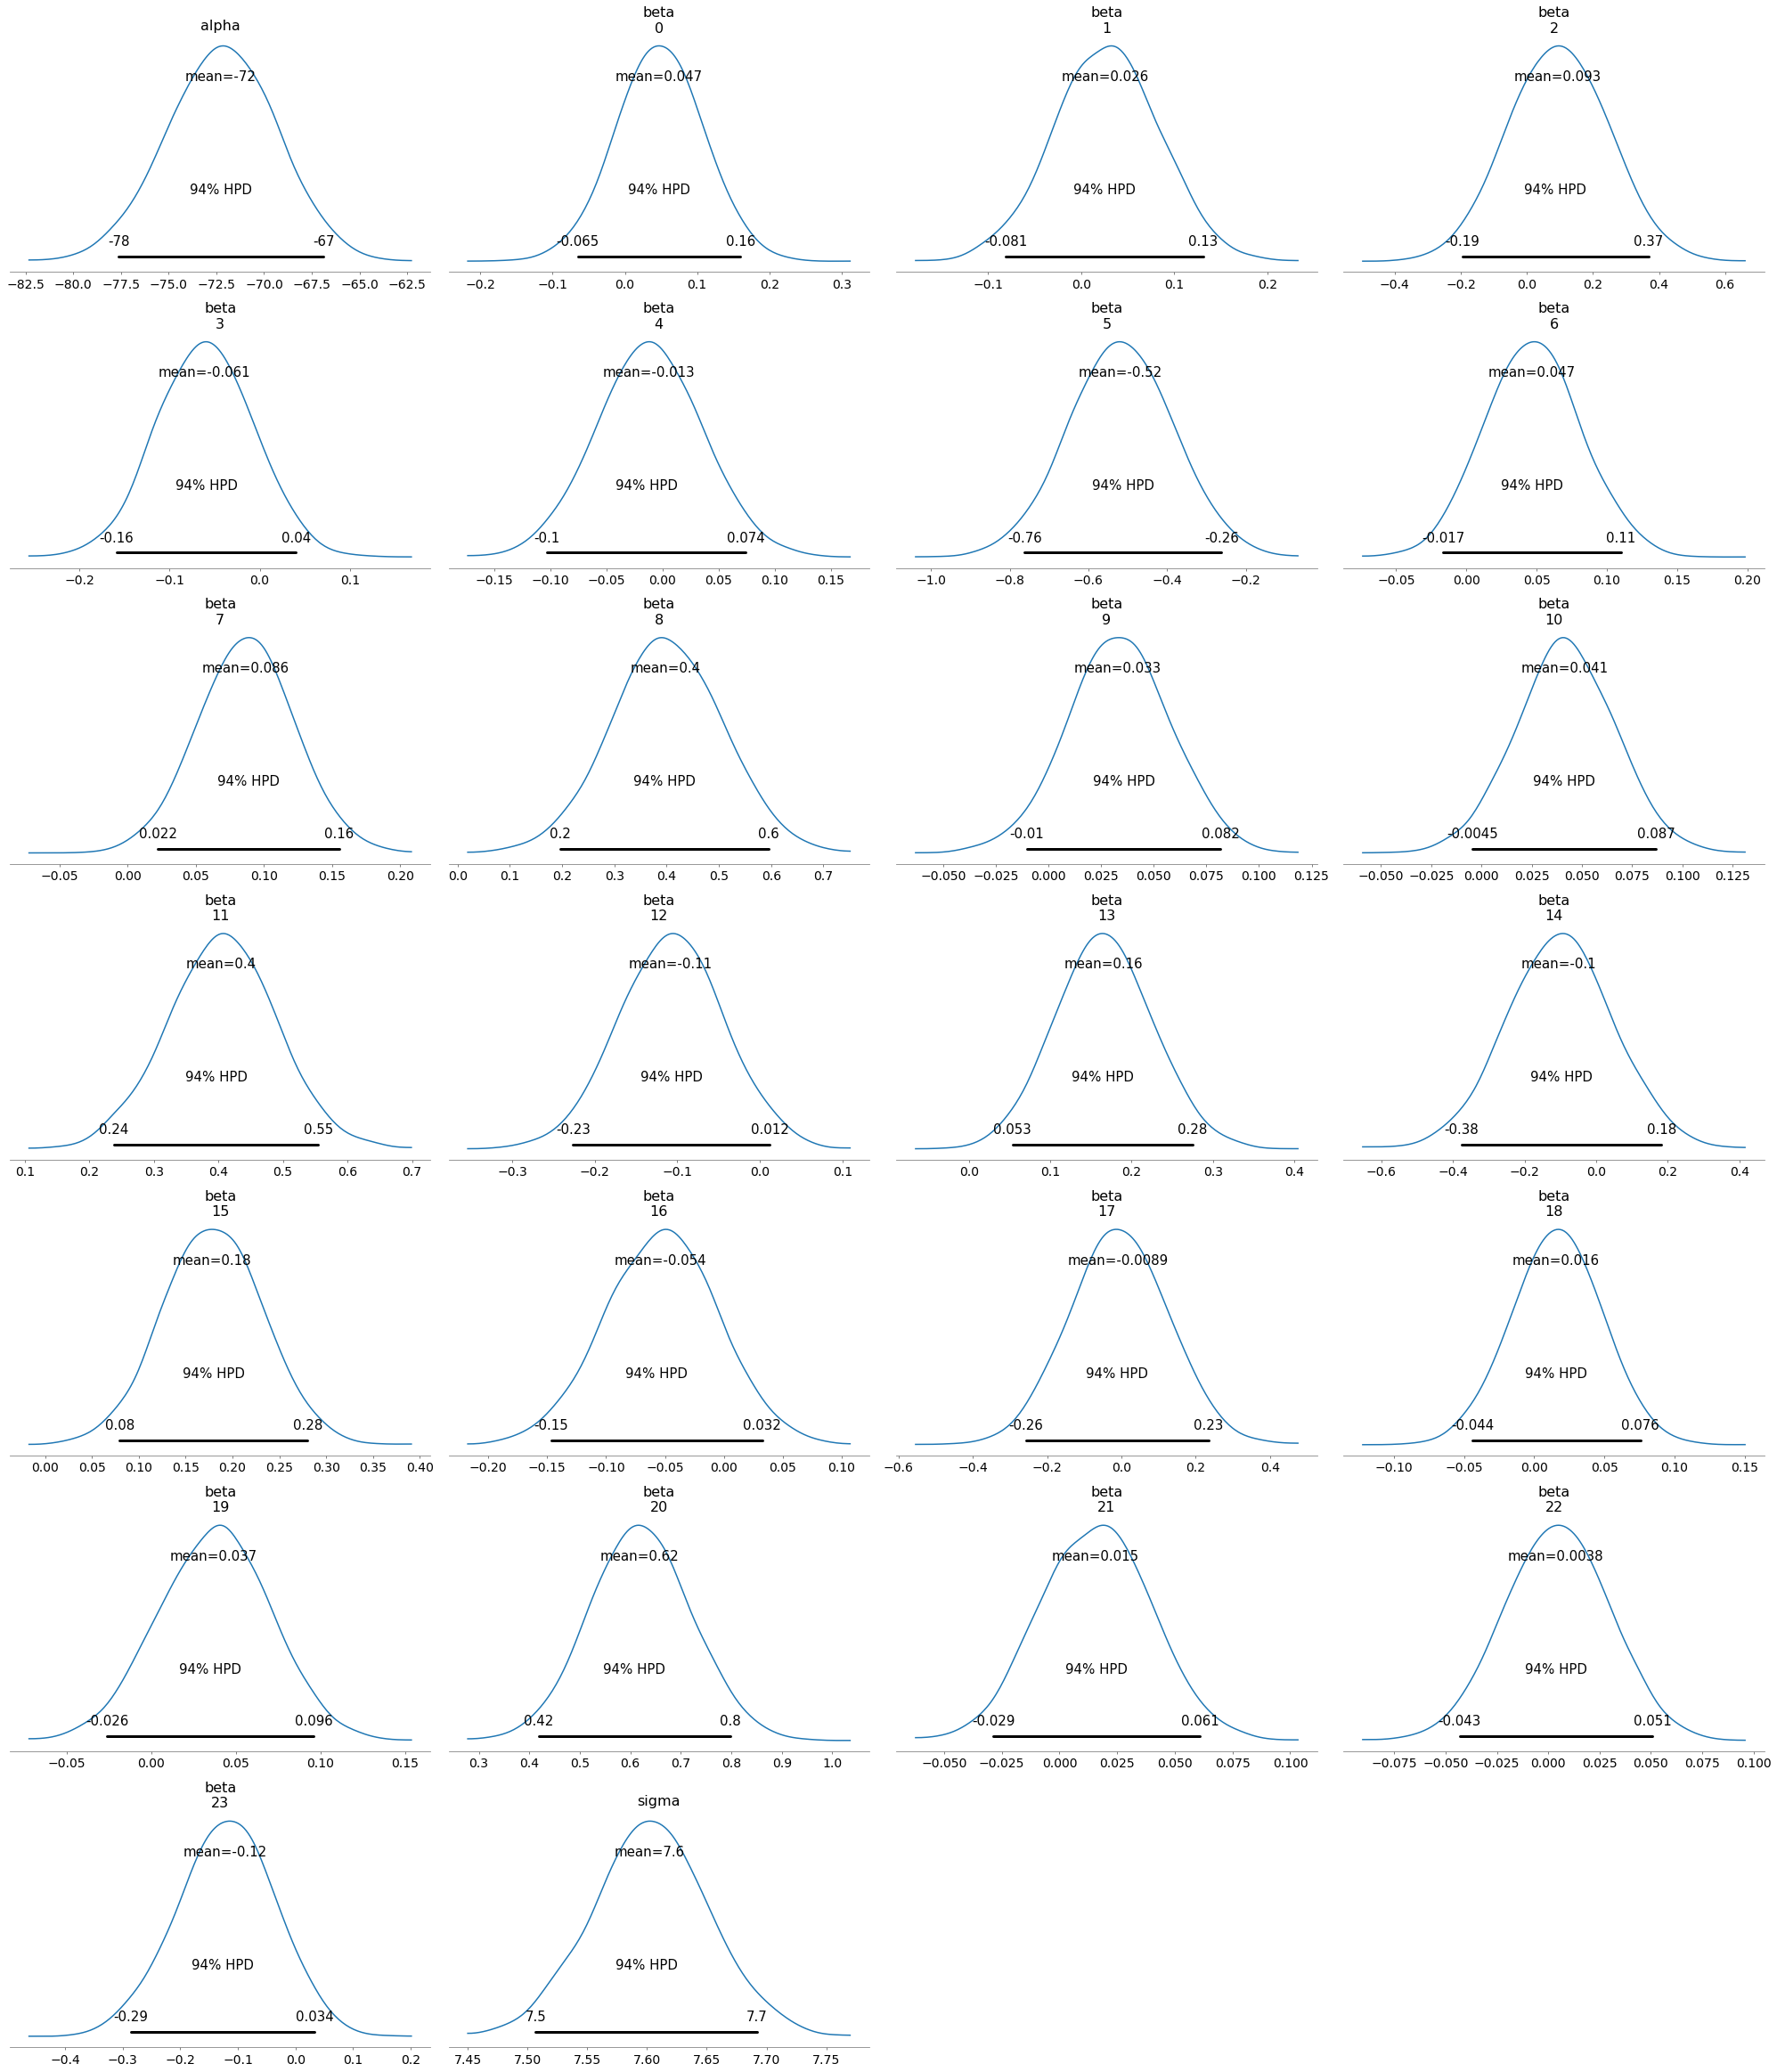

In [52]:
pm.plot_posterior(trace);

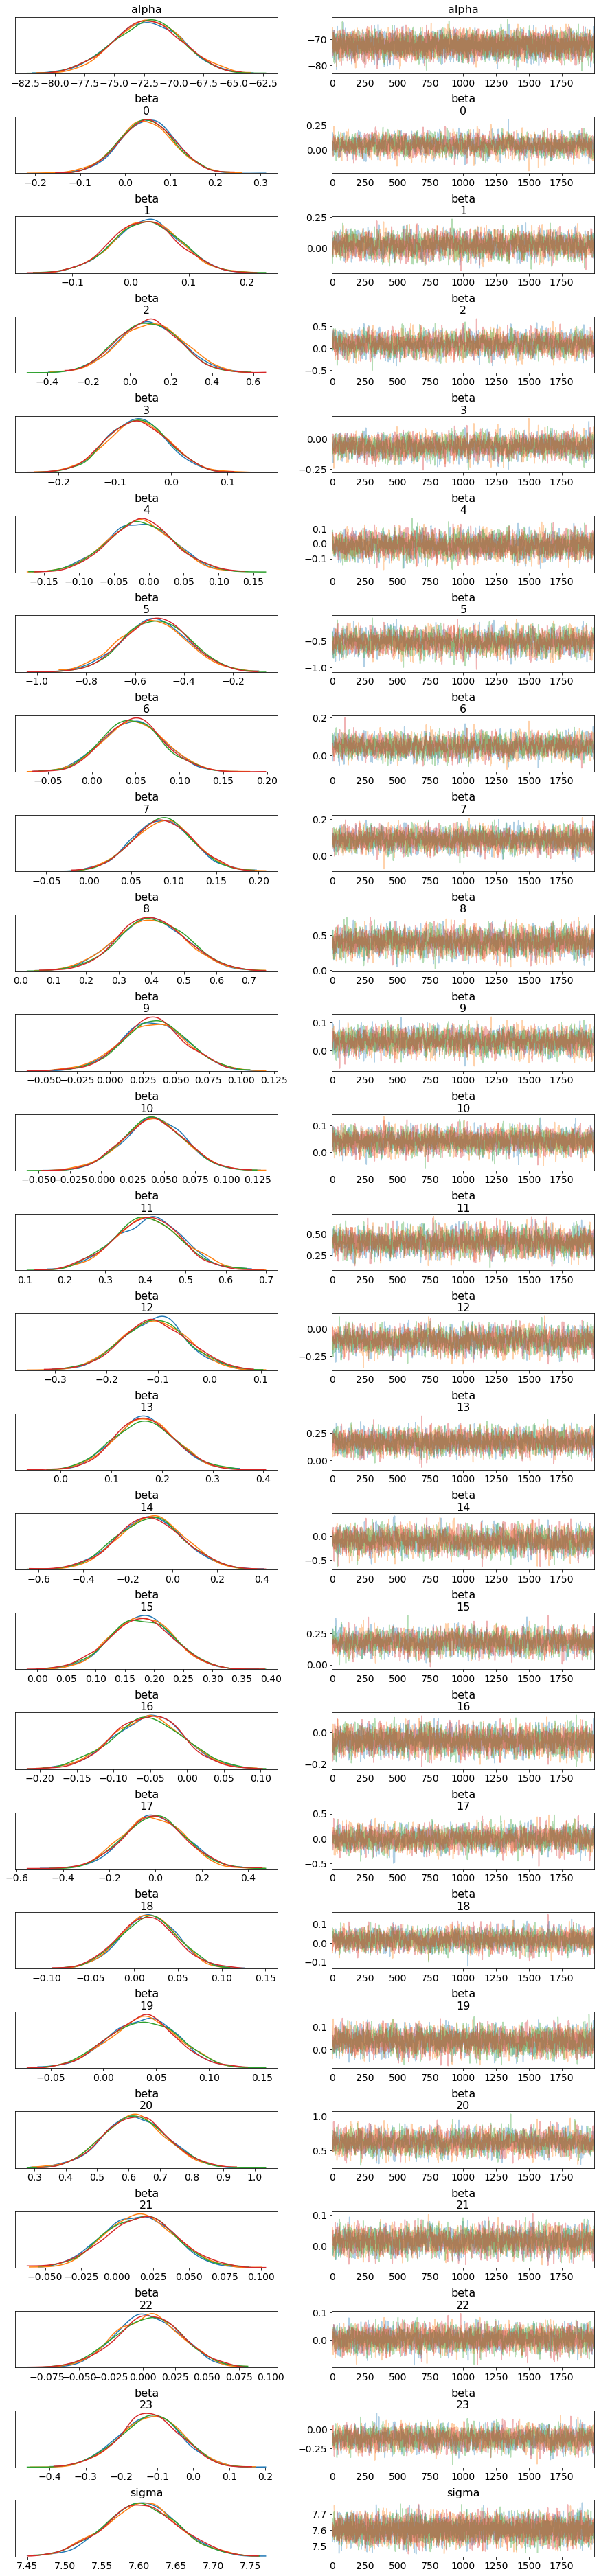

In [53]:
pm.traceplot(trace);

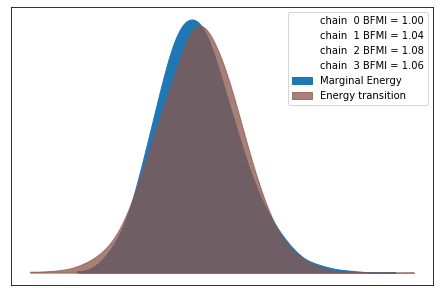

In [58]:
pm.energyplot(trace);

# Posterior Predictive Checks 

In [54]:
with basic_model:
    ppc = pm.sample_posterior_predictive(trace, samples=10000)


100%|██████████| 10000/10000 [00:14<00:00, 668.10it/s]


In [55]:
print(ppc['obs'].shape)
print(ppc['obs'])
# ppc['obs'].mean(axis=1)

(10000, 12316)
[[52.75924571 56.25438738 48.83885765 ... 47.6063079  56.92813149
  57.49224159]
 [51.2283159  69.9918604  50.80494262 ... 58.54931385 55.40768849
  49.06065186]
 [52.33944429 45.07004214 51.21843534 ... 34.00378548 52.76458009
  44.17852906]
 ...
 [60.41463841 51.40374345 46.81696569 ... 58.09981286 55.9325986
  49.74005438]
 [49.92684906 55.17722837 60.6643995  ... 54.10080307 56.6141263
  49.57972581]
 [50.95191591 48.54129998 57.69566577 ... 64.30075729 66.16708491
  52.42493266]]


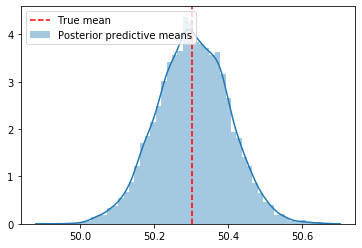

In [56]:
fig, ax = plt.subplots()
sns.distplot(ppc['obs'].mean(axis=1), label='Posterior predictive means', ax=ax)
ax.axvline(y.mean(), ls='--', color='r', label='True mean')
ax.legend(); 

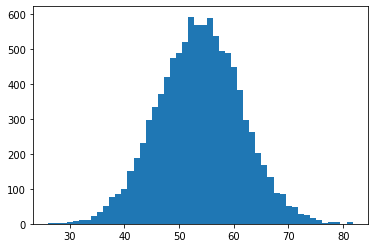

In [57]:
samples_0 = ppc['obs'][:,0]

fig, ax = plt.subplots()
ax.hist(samples_0, bins=50);

In [49]:
print(y[0])
print(samples_0.shape)
print(samples_0.mean())


59
(10000,)
52.65679750096259
